In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from json import load
from pathlib import Path
from pprint import pprint

from mba_tcc.utils.config import get_env_var_as_path

In [28]:
parquet = pd.read_parquet('/home/paulo/Documents/mba_tcc/data/2_final/0__input/001_DISTORTED1sddb40/data.parquet')

In [37]:
parquet.describe(percentiles=np.arange(0, 1., .05))

,vals,train_set,test_set,anomaly_set
count,79795.000000,79795.000000,79795.000000,79795.000000
mean,-27.144590,0.438624,0.561376,0.007782
std,175.478213,0.496222,0.496222,0.087875
min,-1028.681300,0.000000,0.000000,0.000000
0%,-1028.681300,0.000000,0.000000,0.000000
5%,-436.596144,0.000000,0.000000,0.000000
10%,-188.014938,0.000000,0.000000,0.000000
15%,-124.719042,0.000000,0.000000,0.000000
20%,-96.468068,0.000000,0.000000,0.000000
25%,-77.708180,0.000000,0.000000,0.000000


In [29]:
parquet

,vals,train_set,test_set,anomaly_set
0,-142.928840,1,0,0
1,-164.932650,1,0,0
2,-178.507420,1,0,0
3,-181.063060,1,0,0
4,-172.906480,1,0,0
...,...,...,...,...
79790,17.201994,0,1,0
79791,24.004032,0,1,0
79792,27.221281,0,1,0
79793,34.907786,0,1,0


In [31]:
parquet.to_csv("./001_DISTORTED1sddb40.csv")

In [24]:
df = pd.read_csv(
    "./001_DISTORTED1sddb40.csv"
    header=None,
).rename(columns={0: "vals"})

In [26]:
df

,vals
0,-142.928840
1,-164.932650
2,-178.507420
3,-181.063060
4,-172.906480
...,...
79790,17.201994
79791,24.004032
79792,27.221281
79793,34.907786


---

In [90]:
from functools import partial

from hyperopt import fmin, atpe, tpe, hp, STATUS_OK, Trials, pyll

from mba_tcc.utils.config import DEFAULT_VAL_COLUMN

In [156]:
def one_liner_train(data=None, **params):
    k = int(params["K"])
    c = params["C"]
    b = params["B"]
    f_abs = params["f_abs"]
    f_diff = params["f_diff"]
    
    data["tmp"] = data[DEFAULT_VAL_COLUMN]
    
    if f_diff:
        data["tmp"] = data["tmp"].diff()
    
    if f_abs:
        data["tmp"] = data["tmp"].abs()
    
    df_rolling: Rolling = data["tmp"].rolling(window=k)
    df_rolling_mean: pd.Series = df_rolling.mean()
    df_rolling_std: pd.Series = df_rolling.std()
    
    data["predicted_val"] = (k != 1) * df_rolling_mean + c * df_rolling_std + b
    data["predicted_anomaly"] = (data[DEFAULT_VAL_COLUMN] > data["predicted_val"]).astype("int")
    
    return (data["anomaly_set"] - data["predicted_anomaly"] == 0).abs().sum()

def df_params(data: pd.DataFrame = None):
    param_space = {
        'f_abs': hp.choice('f_abs', [0, 1]),
        'f_diff': hp.choice('f_diff', [0, 1]),
        'K': hp.quniform('K', 1, len(df), 1),
        'C': hp.uniform('C', 0, 3),
    }

    df_min = data[DEFAULT_VAL_COLUMN].min()
    df_max = data[DEFAULT_VAL_COLUMN].max()
    
    if df_max <= 5:
        b_range = hp.uniform('B', df_min, df_max)
    else:
        b_range = hp.quniform('B', df_min, df_max, 5)
            
    param_space['B'] = b_range
    
    return param_space

def f(params, data=None):    
    acc = one_liner_train(data=data, **params)
    return {'loss': acc, 'status': STATUS_OK}

def prepare_trial(df):
    param_space = df_params(df)
    func = partial(f, data=df)
    
    return func, param_space

In [157]:
f, params = prepare_trial(parquet)

In [158]:
# evaluated = [pyll.stochastic.sample(params) for _ in range(10)]
# evaluated

Index(['train_set', 'test_set', 'anomaly_set'], dtype='object')

<AxesSubplot: >

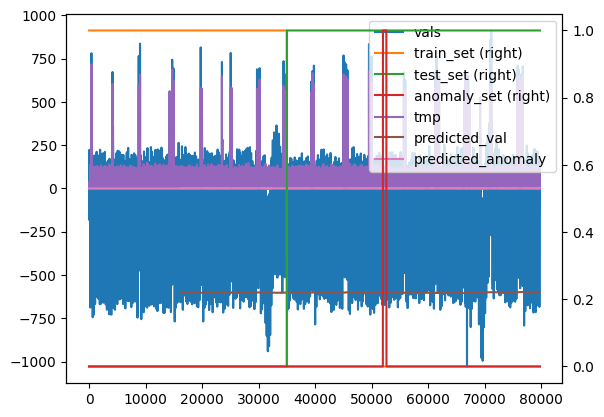

In [168]:
parquet.plot.line(secondary_y=list(parquet.filter(like="_set").columns))

In [159]:
trials = Trials()
best = fmin(f, params, algo=tpe.suggest, max_evals=2500, trials=trialsa)
print("best", best)

 14%|████▏                         | 353/2500 [00:10<01:04, 33.15trial/s, best loss: 657.0]


KeyboardInterrupt: 